In [52]:
from qfrm2.American import *
from FNMethods.ImplicitAm import *
from Reinforcement.src.examples.american_pricing.american_pricing import *
from Reinforcement.src.examples.american_pricing.american_pricing import get_prices_LSPI_FQI
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import pandas as pd
import time

%precision 3
pd.set_option("display.precision", 3)

4. Hestom Model

In [3]:
def HeMC (S0, mu, v0, rho, kappa, theta, xi, T, n):

    # Generate a Monte Carlo simulation for the Heston model, Euler–Maruyama method

    # Generate random Brownian Motion
    dt=T/n
    MU  = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    W_s   = np.random.normal(loc=0.0, scale=1.0, size=n)
    W_t   = np.random.normal(loc=0.0, scale=1.0, size=n)

    # Generate paths
    vt    = np.zeros(n+1)
    vt[0] = v0
    St    = np.zeros(n+1)
    St[0] = S0
    for t in range(1,n+1):
        vt[t] = vt[t-1] + kappa*(theta-np.max(vt[t-1],0))*dt + \
        xi*np.sqrt(np.max(vt[t-1],0)*dt)*(rho*W_s[t-1]+np.sqrt(1-rho**2)*W_t[t-1])
        St[t] = St[t-1]*np.exp((mu - 0.5*np.max(vt[t-1],0))*dt + \
        np.sqrt(np.max(vt[t-1],0)*dt)*W_s[t-1])

    return St, vt

In [4]:
def get_S_V(S0, r, v0, rho, kappa, theta, xi, T, n ,m, rng_seed):

    dt = T/n
    df=np.exp(-r*dt)

    np.random.seed(rng_seed)
    St=np.zeros(shape=(n+1,m))
    vt=np.zeros(shape=(n+1,m))
    for j in range(m):
        St_1,vt_1= HeMC(S0, r, v0, rho, kappa, theta, xi, T, n)
        St[:,j]=St_1
        vt[:,j]=vt_1
    return St,vt

In [5]:
def LSMC_Heston(K,signCP,r,T,rng_seed,n,St,vt):

    dt = T/n
    df=np.exp(-r*dt)
    
    
    payout = np.maximum(signCP * (St - K), 0)
    v = np.copy(payout)  # terminal payouts
    data=np.concatenate(([St],[St**2],[St**3],[vt],[vt**2],[vt**3],\
                 [np.ones_like(St)],[St*vt],[St**2*vt],[St*vt**2]),axis=0) # (10,n+1,m)
        

    # Least-Squares Monte Carlo (LSM):
    for i in range(n - 1, 0, -1):          # American Option Valuation by Backwards Induction
        C = lm_V(data[:,i,:].T,v[i+1] * df)
        v[i] = np.where(payout[i] > C, payout[i], v[i + 1] * df)  # exercise decision
    v[0] = v[1] * df

    return np.mean(v[0])

def lm_V(X,y):
    lm = linear_model.LinearRegression()
    model = lm.fit(X,y)
    C1 = model.predict(X)
    return C1

In [6]:
def GPR_Heston(K,signCP,r,T,rng_seed,n,St,vt,train_size):

      
    dt = T/n
    df=np.exp(-r*dt)


    payout = np.maximum(signCP * (St - K), 0)
    v = np.copy(payout)  # terminal payouts
    #data=np.concatenate(([St],[St**2],[St**3],[vt],[vt**2],[vt**3],\
    #             [np.ones_like(St)],[St*vt],[St**2*vt],[St*vt**2]),axis=0) # (10,n+1,m)
    data=np.concatenate(([St],[vt],[St*vt]),axis=0) # (2,n+1,m)

    # GPR:
    for i in range(n - 1, 0, -1):          # American Option Valuation by Backwards Induction
        C=P_V(data[:,i,:].T,v[i+1] * df,train_size,rng_seed)
        v[i] = np.where(payout[i] > C, payout[i], v[i + 1] * df)  # exercise decision
        #if(i%10==0):print(i,np.mean(v[i]))
            
    v[0] = v[1] * df

    return np.mean(v[0])

def P_V(X,y,train_size,rng_seed):
    X_train, _, y_train, _=train_test_split(X,y,train_size=train_size, random_state=rng_seed)
    rbf  = WhiteKernel() + ConstantKernel()*RBF()
    gpr = GaussianProcessRegressor(kernel=rbf,normalize_y=True,random_state=rng_seed)
    gpr.fit(X_train, y_train)
    C = gpr.predict(X)
    return C

In [7]:
def GPR_Heston_inmoney(K,signCP,r,T,rng_seed,n,St,vt,train_size):

      
    dt = T/n
    df=np.exp(-r*dt)

    payout = np.maximum(signCP * (St - K), 0)
    v = np.copy(payout)  # terminal payouts
    #data=np.concatenate(([St],[St**2],[St**3],[vt],[vt**2],[vt**3],\
    #            [np.ones_like(St)],[St*vt],[St**2*vt],[St*vt**2]),axis=0) # (10,n+1,m)
    data=np.concatenate(([St],[vt],[St*vt]),axis=0) # (3,n+1,m)
    X=np.where(St<K,St,np.nan)


    # GPR:
    for i in range(n - 1, 0, -1):          # American Option Valuation by Backwards Induction
        idx = np.isfinite(X[i])
        C=P_V_inmoney(data[:,i,:].T,v[i+1] * df,train_size,rng_seed,idx)
        v[i] = np.where(payout[i] > C, payout[i], v[i + 1] * df)  # exercise decision
        #if(i%10==0):print(i,np.mean(v[i]),np.sum(idx))
    v[0] = v[1] * df
    return np.mean(v[0])

def P_V_inmoney(X,y,train_size,rng_seed,idx):
    X_train, _, y_train, _=train_test_split(X[idx],y[idx],train_size=train_size, random_state=rng_seed)
    rbf = rbf  = WhiteKernel() + ConstantKernel()*RBF()
    gpr = GaussianProcessRegressor(kernel=rbf,normalize_y=True,random_state=rng_seed)
    gpr.fit(X_train, y_train)
    C = gpr.predict((X[idx]))
    C2=np.zeros_like(y)
    C2[idx]=C
    C2[~idx]=np.nan
    C2=np.where(np.isnan(C2),0,C2)
    return C2

In [31]:
def GPR_Heston_CV(K,signCP,r,T,rng_seed,n,St,vt,train_size):

      
    dt = T/n
    df=np.exp(-r*dt)

    payout = np.maximum(signCP * (St - K), 0)
    v = np.copy(payout)  # terminal payouts (n+1,m)

    data=np.concatenate(([St],[vt],[St*vt]),axis=0) # (3,n+1,m)
    
    Y= np.copy(payout) # (n+1,m)

    # GPR:
    for i in range(n - 1, 0, -1):          # American Option Valuation by Backwards Induction
        X=data[:,i,:].T
        v_discounted=v[i+1] * df
        y_discounted=Y[i+1] * df
        C_V=P_V(X,v_discounted,train_size,rng_seed)
        C_VY=P_V(X,v_discounted*y_discounted,train_size,rng_seed)
        C_Y=P_V(X,y_discounted,train_size,rng_seed)
        C_Y_square=P_V(X,y_discounted**2,train_size,rng_seed)
        v_star=np.divide(C_VY-C_V*C_Y,C_Y_square-C_Y**2,where=((C_Y_square-C_Y**2)!=0))
        Expectation=cal_BS(St[i],vt[i],K,dt*(n-i),r)
        C=C_V-v_star*(C_Y-Expectation)
        v[i] = np.where(payout[i] > C, payout[i], v[i + 1] * df)  # exercise decision
        Y[i] = np.where(payout[i] > C, Expectation, Y[i + 1] * df)
        #if(i%10==0):print(i,np.mean(v[i]))
    v[0] = v[1] * df

    return np.mean(v[0])

def cal_BS(S,v,K,T,rf_r):
    a=np.zeros_like(S)
    for i in range(len(S)):
        s=Stock(S0=S[i],vol=v[i])
        o_e=European(ref=s,right='put', K=K, T=T, rf_r=rf_r)
        a[i]=o_e.pxBS()
    return a

In [23]:
T     = 0.25
S0    = 100 # Initial price
K     = 100
r    = 0.05 # Expected return = risk free return
rho   = -0.7 # Correlation
kappa = 3 # Revert rate
theta = 0.04 # Long-term volatility
xi    = 0.1 # Volatility of instantaneous volatility
v0    = 0.09 # Initial instantaneous volatility
signCP= -1
rng_seed=1
n     = 100 # steps
m     = 1000
St,vt=get_S_V(S0, r, v0, rho, kappa, theta, xi, T, n ,m, rng_seed)

In [71]:
GPR_Heston(K,signCP,r,T,rng_seed,n,St,vt,0.4)

4.085900594699615

In [72]:
GPR_Heston_inmoney(K,signCP,r,T,rng_seed,n,St,vt,0.4)

4.692380314098322

In [62]:
GPR_Heston_CV(K,signCP,r,T,rng_seed,n,St,vt,0.4)

90 4.5576255676128135
80 4.539985148939964
70 4.446254396362314
60 4.234538776833229
50 3.980792953208466
40 3.782740561368144
30 3.551193038269648
20 3.303259989995897
10 2.851875677244481


2.4223247885057058

In [67]:
LSMC_Heston(K,signCP,r,T,rng_seed,n,St,vt)

4.9496433947614165

In [24]:
S0=[90,100,110] # Initial price
K=100
r=0.05
v0=[0.04,0.09,0.16] # Initial instantaneous volatility
T=[0.25,0.5]
K     = 100
r    = 0.05 # Expected return = risk free return
rho   = -0.7 # Correlation
kappa = 3 # Revert rate
theta = 0.04 # Long-term volatility
xi    = 0.1 # Volatility of instantaneous volatility
signCP= -1
rng_seed=1
n     = 100 # steps
m     = 500

train_size=0.4

In [91]:
method=['LSM','GPR','GPR_IM','GPR_CV']
iterables = [S0, v0, T]
index = pd.MultiIndex.from_product(iterables, names=['S0', 'sigma','T'])
df = pd.DataFrame(np.zeros(shape=(index.shape[0],len(method))),columns=method, index=index)

In [98]:
rng_seed=1
for i in [110]:
    for j in v0:
        for k in T:
            print(i,j,k,rng_seed)
            rng_seed += 1
            St,vt=get_S_V(i, r, j, rho, kappa, theta, xi, k, n ,m,rng_seed )
            df.loc[(i,j,k),'LSM']=LSMC_Heston(K,signCP,r,k,rng_seed,n,St,vt)
            df.loc[(i,j,k),'GPR']=GPR_Heston(K,signCP,r,k,rng_seed,n,St,vt,train_size)
            #df.loc[(i,j,k),'GPR_IM']=GPR_Heston_inmoney(K,signCP,r,k,rng_seed,n,St,vt,train_size)
            df.loc[(i,j,k),'GPR_CV']=GPR_Heston_CV(K,signCP,r,k,rng_seed,n,St,vt,train_size)


110 0.04 0.25 1


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.259e-05,  2.650e-05, -1.718e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


110 0.04 0.5 2
110 0.09 0.25 3
110 0.09 0.5 4
110 0.16 0.25 5
110 0.16 0.5 6


In [144]:
df

LSM     GPR  GPR_IM  GPR_CV
S0  sigma T                                   
90  0.04  0.25  10.363  10.257  10.360   9.998
          0.50  10.812  10.333  10.493   9.992
    0.09  0.25  11.281  10.524  10.653   9.967
          0.50  11.813  10.806  10.838   9.973
    0.16  0.25  12.803  11.903  12.153   9.941
          0.50  13.558  12.137  12.361  10.400
100 0.04  0.25   3.709   3.287   3.374   0.956
          0.50   4.892   4.058   4.451   0.771
    0.09  0.25   5.026   3.721   4.542   2.369
          0.50   5.967   4.705   5.630   2.568
    0.16  0.25   6.481   5.265   5.870   3.828
          0.50   8.327   6.813   7.887   3.596
110 0.04  0.25   0.816   0.784   0.000   0.008
          0.50   1.443   1.370   0.000   0.005
    0.09  0.25   1.739   1.433   0.000   0.004
          0.50   2.627   2.147   0.000   0.098
    0.16  0.25   3.191   2.388   0.000   0.063
          0.50   4.600   3.128   0.000   0.225

In [143]:
#df.to_csv('./Running results/HestonAmericanPut') 
df=pd.read_csv('./Running results/HestonAmericanPut',index_col=[0,1,2]) # load

- By steps

In [117]:
method=['LSM','GPR','GPR_IM','GPR_CV']
df_by_steps = pd.DataFrame(np.zeros(shape=(20,len(method))),columns=method, \
                           index=pd.Index(np.arange(10,210,10)))

In [120]:
rng_seed=1
S0=100
v0=0.09
T=0.25
for n in np.arange(10,210,10):

    print(n,rng_seed)
    rng_seed += 1
    St,vt=get_S_V(S0, r, v0, rho, kappa, theta, xi, T, n ,m,rng_seed )
    df_by_steps.loc[n,'LSM']=LSMC_Heston(K,signCP,r,T,rng_seed,n,St,vt)
    df_by_steps.loc[n,'GPR']=GPR_Heston(K,signCP,r,T,rng_seed,n,St,vt,train_size)
    df_by_steps.loc[n,'GPR_IM']=GPR_Heston_inmoney(K,signCP,r,k,rng_seed,n,St,vt,train_size)
    df_by_steps.loc[n,'GPR_CV']=GPR_Heston_CV(K,signCP,r,T,rng_seed,n,St,vt,train_size)


10 1
20 2
30 3
40 4
50 5
60 6
70 7
80 8
90 9
100 10
110 11
120 12
130 13
140 14
150 15
160 16
170 17
180 18
190 19


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.393e-05, -5.285e-06,  6.374e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 33, 'warnflag': 2}
  ConvergenceWarning)


200 20


In [137]:
df_by_steps.to_csv('./Running results/HestonAmericanPut_bysteps') 
#df_by_steps=pd.read_csv('SimpleAmericanPut_se',index_col=[0,1,2]) # load

In [122]:
df_by_steps

,LSM,GPR,GPR_IM,GPR_CV
10,5.234,4.417,4.786,3.346
20,4.941,4.289,4.866,2.992
30,5.201,3.881,4.590,2.187
40,4.794,3.688,4.259,2.862
50,5.318,4.318,4.861,2.988
60,5.123,3.963,4.575,2.625
70,4.669,3.922,4.724,2.159
80,4.980,4.152,4.789,2.273
90,4.948,4.051,4.521,1.508
100,4.689,3.984,4.575,1.596


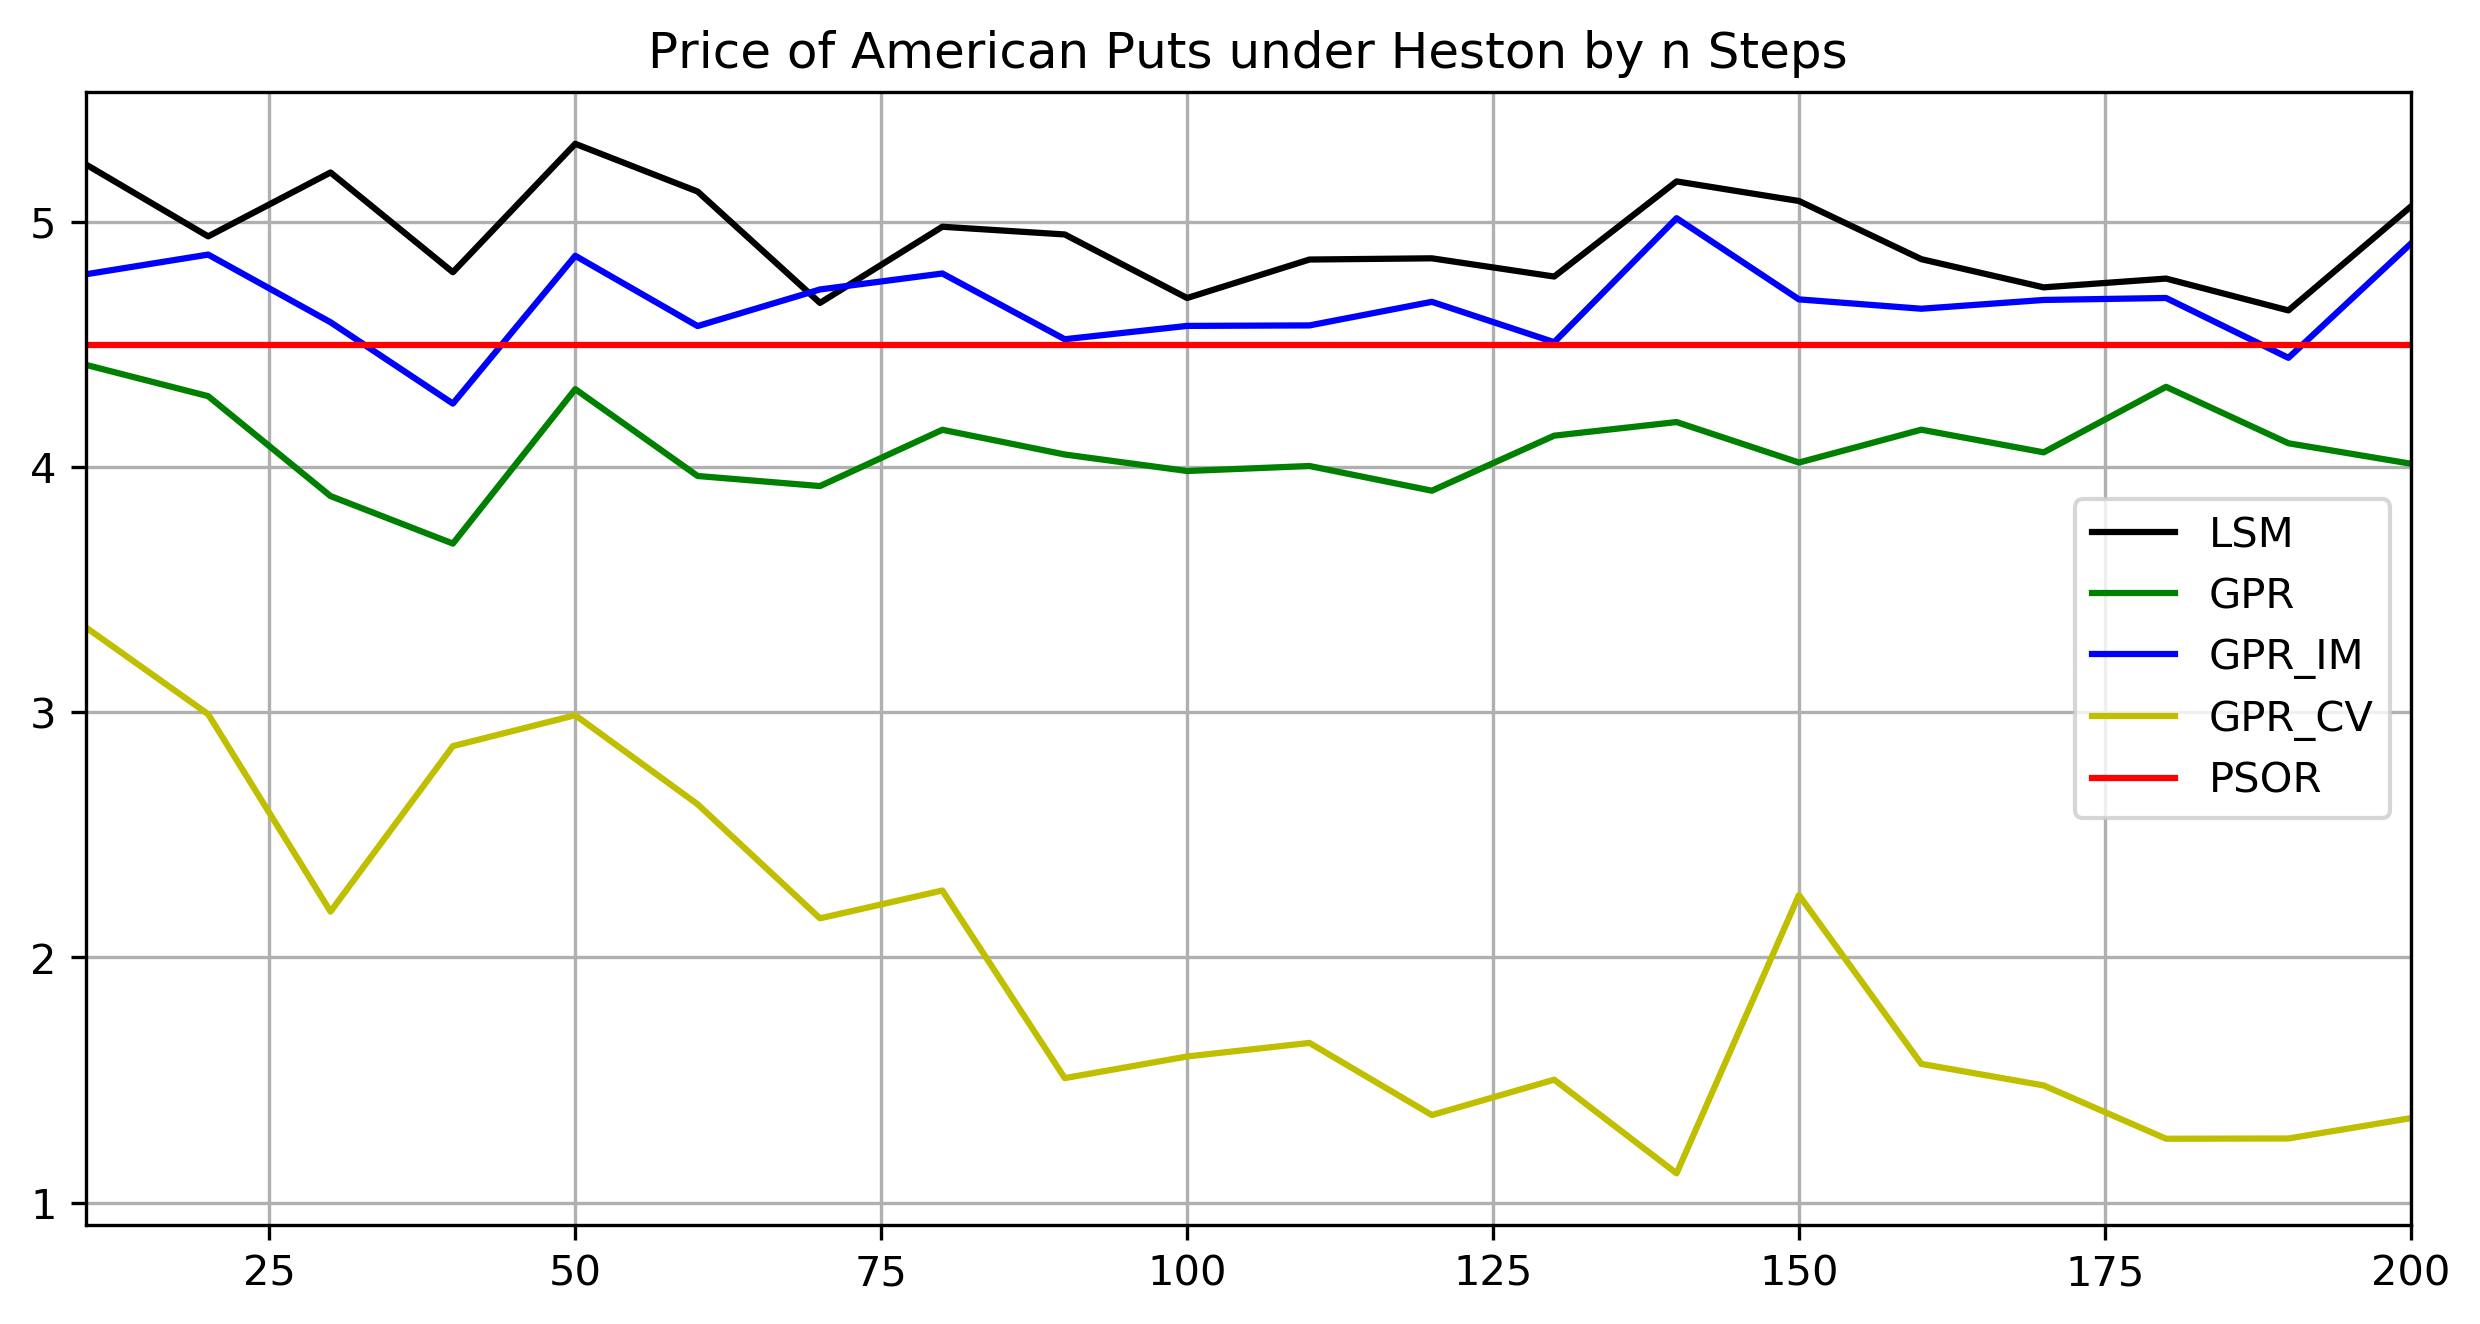

In [136]:
plt.rcParams["figure.dpi"] = 300
df_by_steps.\
plot(grid=0.1, title='Price of American Puts under Heston by n Steps',figsize=(10,5),color=['k','g','b','y','r'])

- Standard Errors

In [49]:
method=['LSM','GPR','GPR_IM','GPR_CV']
iterables = [S0, v0, T]
index = pd.MultiIndex.from_product(iterables, names=['S0', 'sigma','T'])
df_se = pd.DataFrame(np.zeros(shape=(index.shape[0],len(method))),columns=method, index=index)
df_time = pd.DataFrame(np.zeros(shape=(index.shape[0],len(method))),\
                       columns=np.core.defchararray.add(method, ['_time']), index=index)

In [76]:
v0

[0.040, 0.090, 0.160]

In [93]:
rng_seed=1
for i in S0:
    for j in v0:
        for k in T:
            print(i,j,k,rng_seed)
            rng_seed += 1
            LSM=np.zeros(25)
            GPR=np.zeros(25)
            GPR_IM=np.zeros(25)
            GPR_CV=np.zeros(25)
            start = time.time()
            for q in range(25):
                St,vt=get_S_V(i, r, j, rho, kappa, theta, xi, k, n ,m,rng_seed+q)
                GPR_CV[q]=GPR_Heston_CV(K,signCP,r,k,rng_seed+q,n,St,vt,train_size)
            end= time.time()
            df_se.loc[(i,j,k),'GPR_CV']=np.std(GPR_CV,ddof=1)
            df_time.loc[(i,j,k),'GPR_CV_time']=end-start
            #df_se.loc[(i,j,k),'GPR']=np.std([GPR_Heston(K,signCP,r,k,rng_seed+q,n,St,vt,train_size)\
            #                              for q in range(25)],ddof=1)
            #df.loc[(i,j,k),'GPR_IM']=GPR_Heston_inmoney(K,signCP,r,k,rng_seed,n,St,vt,train_size)
            #df_se.loc[(i,j,k),'GPR_CV']=np.std([GPR_Heston_CV(K,signCP,r,k,rng_seed+q,n,St,vt,train_size)\
            #                              for q in range(25)],ddof=1)


90 0.04 0.25 1
90 0.04 0.5 2
90 0.09 0.25 3
90 0.09 0.5 4
90 0.16 0.25 5
90 0.16 0.5 6
100 0.04 0.25 7
100 0.04 0.5 8
100 0.09 0.25 9
100 0.09 0.5 10


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.507e-05,  1.336e-06, -1.664e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


100 0.16 0.25 11


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.394e-07, -9.319e-06,  3.320e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


100 0.16 0.5 12
110 0.04 0.25 13


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.345e+01, -9.474e-04,  8.736e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.664e+01, -6.736e-04, -2.748e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.543e+01, -4.700e-04,  3.924e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)
/Users/lij

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.410e+01, -4.145e-04,  2.067e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 129, 'nit': 51, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([43.372, -1.217,  0.19 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.396e+01, -1.594e-05,  1.558e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/

110 0.04 0.5 14


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.   , -0.001,  0.004]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 117, 'nit': 40, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.727e+01, -3.295e-04,  2.082e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.   , -0.   ,  0.001]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/li

110 0.09 0.25 15


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.617e-05, -2.030e-04,  2.053e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.051e-05,  3.201e-05, -1.365e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.247e-05, -3.389e+00,  6.549e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/Users/lij

110 0.09 0.5 16
110 0.16 0.25 17
110 0.16 0.5 18


In [99]:
df_se

LSM    GPR  GPR_IM  GPR_CV
S0  sigma T                                 
90  0.04  0.25  0.181  0.156   0.123   0.052
          0.50  0.284  0.261   0.207   0.069
    0.09  0.25  0.318  0.255   0.234   0.064
          0.50  0.478  0.298   0.267   0.114
    0.16  0.25  0.414  0.332   0.313   0.197
          0.50  0.517  0.344   0.320   0.580
100 0.04  0.25  0.200  0.234   0.252   0.143
          0.50  0.281  0.208   0.222   0.131
    0.09  0.25  0.259  0.208   0.239   0.414
          0.50  0.320  0.262   0.283   0.491
    0.16  0.25  0.311  0.257   0.247   0.465
          0.50  0.392  0.405   0.340   0.965
110 0.04  0.25  0.113  0.129   0.000   0.004
          0.50  0.191  0.187   0.000   0.005
    0.09  0.25  0.158  0.151   0.000   0.013
          0.50  0.187  0.231   0.000   0.065
    0.16  0.25  0.185  0.168   0.000   0.037
          0.50  0.228  0.286   0.000   0.222

In [98]:
df_time

LSM_time  GPR_time  GPR_IM_time  GPR_CV_time
S0  sigma T                                                 
90  0.04  0.25     1.502    12.208        8.304       36.680
          0.50     1.478    13.665       12.253       41.445
    0.09  0.25     1.478    13.412       12.378       45.064
          0.50     1.701    13.026       12.503       43.545
    0.16  0.25     1.553    12.867       12.295       43.877
          0.50     1.625    13.535       11.666       43.376
100 0.04  0.25     1.458     9.131        5.128       34.404
          0.50     1.531    12.575        7.527       36.237
    0.09  0.25     1.478    12.355        7.697       36.147
          0.50     1.510    12.931        7.708       41.278
    0.16  0.25     1.558    12.764        8.089       45.323
          0.50     1.475    12.842        7.498       48.527
110 0.04  0.25     1.456    10.373       10.373       37.142
          0.50     1.477    13.437       13.437       34.991
    0.09  0.25     1.496    13.422       13.422       35.248
          0.50     1.475    14.125       14.125       37.321
    0.16  0.25     1.479    14.479       14.479       38.495
          0.50     1.482    12.811       12.811       44.515

In [101]:
#df_se.to_csv('./Running results/HestonAmericanPut_se') 
#df_time.to_csv('./Running results/HestonAmericanPut_TIME') 
#df_se=pd.read_csv('./Running results/HestonAmericanPut_se',index_col=[0,1,2]) # load
#df_time=pd.read_csv('./Running results/HestonAmericanPut_TIME',index_col=[0,1,2]) # load